# Sequential Minimal Optimization

This notebook implements SMO as introduced in "Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines" by John C. Platt.

In [27]:
#Task 1 
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions


def linear_kernel(x1, x2):
    return x1.T @ x2


class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        elif eta < 0:
            Lobj = self.objective_function(i1, L)  
            Hobj = self.objective_function(i1, H)  

            if Lobj < Hobj - self._tol:
                a2 = L
            elif Lobj > Hobj + self._tol:
                a2 = H
            else:
                a2 = alpha2
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")

        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)

        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range(self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def objective_function(self, i1, alpha2):
        x1 = self._data[i1]
        y1 = self._targets[i1]
        alpha1 = self._alphas[i1]

        k11 = self._k(x1, x1)
        k22 = self._k(x1, x1)
        k12 = self._k(x1, x1)

        e1 = self.predict_score(x1) - y1
        e2 = e1 - alpha1 * y1 * (alpha2 - self._alphas[i1]) * k11 + alpha2 * y1 * (alpha2 - self._alphas[i2]) * k12

        return e2

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        # -self._tol < r2 < self._tol when point i2 is on the boundary
        # See (12) in Platt's paper
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with largest absolute difference |e1 - e2|

                max_step = 0
                for i, v in enumerate(f_idxs):
                    if v == i2:
                        continue

                    if self._error_cache[v] == 0:
                        self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                    step = np.abs(self._error_cache[v] - e2)

                    if step > max_step:
                        max_step = step
                        i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0

    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                random_idxs = np.random.permutation(np.arange(data.shape[0]))
                for i in random_idxs:
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                random_idxs = np.random.permutation(f_idxs)
                for i, v in enumerate(random_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [13]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


[ 0.60648785 -1.07014398]
0.11374000567862574
weights=[ 0.60648785 -1.07014398]
b=0.11374000567862574


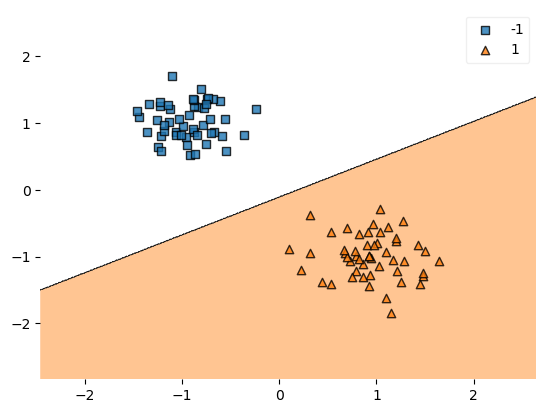

In [14]:
# for i in range(samples.shape[0]):
#     print(f"Sample {i}: score={model.predict_score(samples[i])}, alpha={model._alphas[i]}")
model = svm(c=1)
model.fit(samples, targets)
print(model._weights)
print(model._b)

print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[ 0.8190781  -0.65725882]]
intercept=[-0.03861194]


/Users/vyshali/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


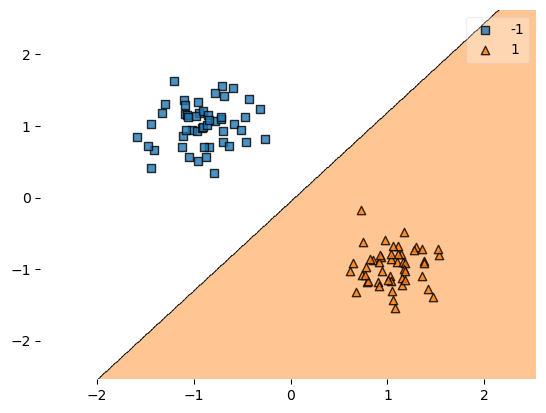

In [4]:
from sklearn.svm import LinearSVC


sk_model = LinearSVC()
sk_model.fit(samples, targets.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

In [31]:
#Task2 - kernel matrix is not positive semidefinite
import numpy as np
x = np.array([1, 2, 3])
y = np.array([1, 2, 3])
km = np.outer(x, y)
evals = np.linalg.eigvals(km)
if any(evals < 0):
    print("The kernel matrix is not positive semidefinite.")
    print("Eigenvalues:", evals)
else:
    print("The kernel matrix is positive semidefinite.")
    print("Eigenvalues:", evals)


The kernel matrix is not positive semidefinite.
Eigenvalues: [ 1.40000000e+01  2.64152997e-16 -4.59474257e-16]


Custom SVM(Poly) accuracy: 0.00
sklearn SVC(Linear) accuracy: 0.42
Best sklearn SVC(Poly) accuracy: 0.98
Best sklearn SVC(Linear) accuracy: 0.42


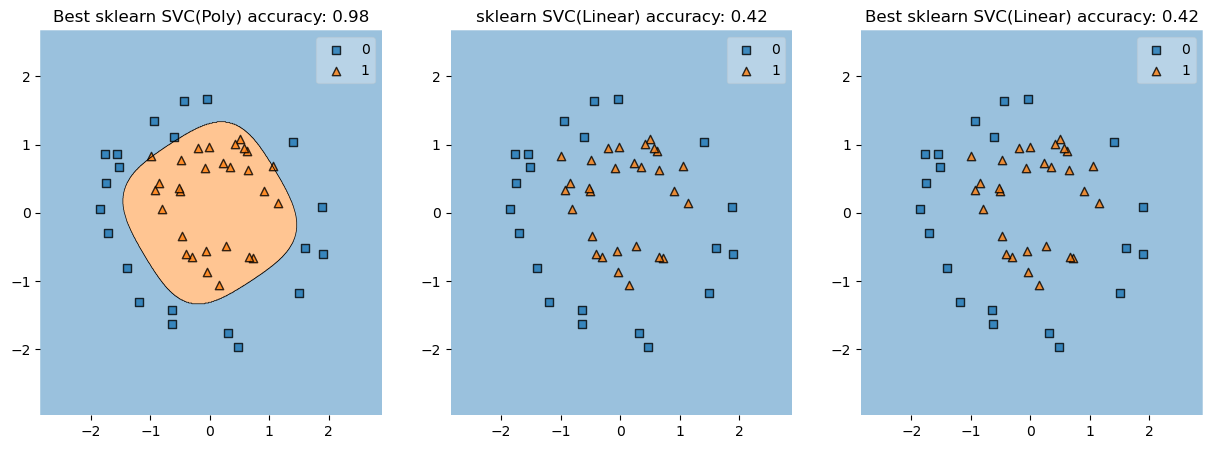

In [29]:
#Non linear SVM
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.datasets import make_circles
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

def linear_kernel(x1, x2):
    return x1 @ x2.T

def poly_kernel(x1, x2, degree=3):
    if len(x1.shape) == 1:
        return (x1 @ x2.T + 1)**degree
    else:
        return (x1 @ x2.T + 1)**degree

class SVM:
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self._c = c
        self._eps = 1e-6  

    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0

    def predict_score(self, x):
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        elif self._kernel == 'poly':
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * poly_kernel(self._data[i], x) 
            u -= self._b
        return u
        
    def predict(self, x):
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0
        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2
        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = poly_kernel(x1, x1)  
        k22 = poly_kernel(x2, x2)  
        k12 = poly_kernel(x1, x2) 

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        else:
            Lobj = self.objective_function(i1, L)  
            Hobj = self.objective_function(i1, H)

            if Lobj < Hobj - self._eps:
                a2 = L
            elif Lobj > Hobj + self._eps:
                a2 = H
            else:
                a2 = alpha2

        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        self._alphas[i1] = a1
        self._alphas[i2] = a2
        for i in range(self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]
        return 1

    def objective_function(self, i1, alpha2):
        x1 = self._data[i1]
        y1 = self._targets[i1]
        alpha1 = self._alphas[i1]

        k11 = poly_kernel(x1, x1)  
        k22 = poly_kernel(x1, x1)  
        k12 = poly_kernel(x1, x1)  

        e1 = self.predict_score(x1) - y1
        e2 = e1 - alpha1 * y1 * (alpha2 - self._alphas[i1]) * k11 + alpha2 * y1 * (alpha2 - self._alphas[i2]) * k12

        return e2

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                max_step = 0
                for i, v in enumerate(f_idxs):
                    if v == i2:
                        continue

                    if self._error_cache[v] == 0:
                        self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                    step = np.abs(self._error_cache[v] - e2)

                    if step > max_step:
                        max_step = step
                        i1 = v

                if self.smo_step(i1, i2):
                    return 1
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0

    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        self._init_params()
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                random_idxs = np.random.permutation(np.arange(data.shape[0]))
                for i in random_idxs:
                    n_changed += self.examine(i)
            else:
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                random_idxs = np.random.permutation(f_idxs)
                for i, v in enumerate(random_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

if __name__ == "__main__":
    X, y = make_circles(n_samples=500, factor=0.5, noise=0.1, random_state=42)
    xtr, xt, ytr, yt = train_test_split(X, y, test_size=0.1, random_state=42)

    s = StandardScaler()
    xtr = s.fit_transform(xtr)
    xt = s.transform(xt)

    csp = SVM(kernel='poly', c=1)
    csp.fit(xtr, ytr)
    ypcp = csp.predict(xt)
    accpol = accuracy_score(yt, ypcp)
    print(f"Custom SVM(Poly) accuracy: {accpol:.2f}")

    sklin = SVC(kernel='linear', C=1)
    sklin.fit(xtr, ytr)
    ysklin = sklin.predict(xt)
    acclin = accuracy_score(yt, ysklin)
    print(f"sklearn SVC(Linear) accuracy: {acclin:.2f}")

    pg = {
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
    }
    gridpol = GridSearchCV(SVC(kernel='poly'), pg, cv=3)
    gridpol.fit(xtr, ytr)
    bsvpol = gridpol.best_estimator_
    ybespol = bsvpol.predict(xt)
    accbpol = accuracy_score(yt, ybespol)
    print(f"Best sklearn SVC(Poly) accuracy: {accbpol:.2f}")

    pg = {
        'C': [0.1, 1, 10],
    }
    gridlin = GridSearchCV(SVC(kernel='linear'), pg, cv=3)
    gridlin.fit(xtr, ytr)
    bsvlin = gridlin.best_estimator_
    yblin = bsvlin.predict(xt)
    accblin = accuracy_score(yt, yblin)
    print(f"Best sklearn SVC(Linear) accuracy: {accblin:.2f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = plot_decision_regions(xt, yt, clf=bsvpol, ax=axes[0])
ax.set_title(f'Best sklearn SVC(Poly) accuracy: {accbpol:.2f}')

ax = plot_decision_regions(xt, yt, clf=sklin, ax=axes[1])
ax.set_title(f'sklearn SVC(Linear) accuracy: {acclin:.2f}')

ax = plot_decision_regions(xt, yt, clf=bsvlin, ax=axes[2])
ax.set_title(f'Best sklearn SVC(Linear) accuracy: {accblin:.2f}')

plt.show()


In [26]:
#Multi class SVM
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

class SVM:
    def __init__(self, kernel='linear', c=1.0):
        self.kernel = kernel
        self.c = c
        self.model = None

    def fit(self, xtr, ytr):
        if self.kernel == 'linear':
            self.model = SVC(kernel='linear', C=self.c)
        elif self.kernel == 'poly':
            self.model = SVC(kernel='poly', degree=3, C=self.c)
        self.model.fit(xtr, ytr)

    def predict(self, xt):
        return self.model.predict(xt)

class MultiSVM:
    def __init__(self, kernel='linear', c=1.0):
        self.kernel = kernel
        self.c = c
        self.models = []

    def fit(self, xtr, ytr):
        for i in range(len(np.unique(ytr))):
            y_binary = (ytr == i).astype(int)
            model = SVM(kernel=self.kernel, c=self.c)
            model.fit(xtr, y_binary)
            self.models.append(model)
            
    def predict(self, xt):
        scores = np.array([model.model.decision_function(xt) for model in self.models])
        return np.argmax(scores, axis=0)


d = load_iris()
X, y = d.data, d.target
xtr, xt, ytr, yt = train_test_split(X, y, test_size=0.3, random_state=42)
s = StandardScaler()
xtr = s.fit_transform(xtr)
xt = s.transform(xt)

cmsvlin = MultiSVM(kernel='linear', c=1)
cmsvlin.fit(xtr, ytr)
ypclin = cmsvlin.predict(xt)
acclin = accuracy_score(yt, ypclin)
print(f"Custom MultiSVM(Linear) accuracy: {acclin:.2f}")

csvmpol = MultiSVM(kernel='poly', c=1)
csvmpol.fit(xtr, ytr)
ycuspol = csvmpol.predict(xt)
accpol = accuracy_score(yt, ycuspol)
print(f"Custom MultiSVM(Poly) accuracy: {accpol:.2f}")

ovrlin = OneVsRestClassifier(SVC(kernel='linear', C=1))
ovrlin.fit(xtr, ytr)
yplin = ovrlin.predict(xt)
accslin = accuracy_score(yt, yplin)
print(f"Sklearn OneVsRest(Linear) accuracy: {accslin:.2f}")

ovrpol = OneVsRestClassifier(SVC(kernel='poly', C=1))
ovrpol.fit(xtr, ytr)
yppol = ovrpol.predict(xt)
accspol = accuracy_score(yt, yppol)
print(f"Sklearn OneVsRest(Poly) accuracy: {accspol:.2f}")



Custom MultiSVM(Linear) accuracy: 0.96
Custom MultiSVM(Poly) accuracy: 0.91
Sklearn OneVsRest(Linear) accuracy: 0.96
Sklearn OneVsRest(Poly) accuracy: 0.91
